In [1]:
from database.utils import reconstruct_probs
from models.SVM.binary_classification import tune_hyperparams, perform_skfold, optimise_score_over_channels, average_probabilities
from database.data import Data
from sklearn.svm import SVC
from tqdm import tqdm
import numpy as np


In [2]:
#creating DATA object
ptb_binary_SVM = Data(database = 'ptbdb', denoise_method='DWT', estimation_method = 'SVM', train_splits=None, binary = True, parameterisation = True)


# define hyperparameter grid to test
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale']#including 'auto' aswell takes forever
}


In [9]:
repeats = 3

best_scores = []
best_channels = []

optimal_probs = []


#nan_indices_list = []
av_thresholds_list = []

scores_dict_list = []


for j in tqdm(range(repeats)):

    ptb_binary_SVM.run()

    input_data = ptb_binary_SVM.input_data
    labels = ptb_binary_SVM.labels
    
    metrics = {}
    
    probs_list = []
    thresholds_list = []

    for i in range(6):
        labels_encoded = np.array([0 if label == 'Unhealthy' else 1 for label in labels[i]])

        #define classifier
        svc = SVC(class_weight='balanced', probability = True)

        #find the best set of hyperparameters for each channel, tuned on the desired scoring function
        best_svc = tune_hyperparams(input_data[i], labels_encoded, param_grid, svc, scorer='roc_auc')

        #perform 3 way skfold to get scores for each channel as well as their probabilities
        n_splits = 3
        all_score_metrics, thresholds, probabilities, y_tests, test_indices = perform_skfold(input_data[i], labels_encoded, n_splits, best_svc, get_probabilities=True)

        #monitoring scores for each channel
        metrics[i] = all_score_metrics

        #calculating average threshold from all splits
        threshold = np.mean(thresholds)

        #reconstructing calculated probabilities so can optimise over all channels
        reconstructed_probs = reconstruct_probs(probabilities, test_indices, ptb_binary_SVM.nan_indices[i], ptb_binary_SVM.allowed_patients.count_patients(), n_splits)


        #need for ROC curve and confusion matrix later
        probs_list.append(reconstructed_probs)
        thresholds_list.append(threshold)

    


    #for averaging 
    scores_dict_list.append(metrics)

    #optimising over channels
    av_threshold = np.mean(thresholds_list)
    best_score, best_channel_indices = optimise_score_over_channels(probs_list, av_threshold, ptb_binary_SVM.health_state)

    best_scores.append(best_score)
    best_channels.append(best_channel_indices)


    #calculating optimal probability
    best_prob = average_probabilities(probs_list, best_channel_indices)
    optimal_probs.append(best_prob)
    av_thresholds_list.append(av_threshold)


  0%|          | 0/3 [00:00<?, ?it/s]

Filtering Database


100%|██████████| 221/221 [00:05<00:00, 38.40it/s]


calculating time domain parameters
calculating frequency domain parameters
calculating non linear domain parameters
selecting 4 most important features
Selected features for channel 1:
['shannon_en', 'sd_ratio', 'sd2', 'age']
Selected features for channel 2:
['rr_std', 'rr_amps', 'power_ratio', 'age']
Selected features for channel 3:
['rr_std', 'rr_amps', 'sd2', 'age']
Selected features for channel 4:
['skews', 'lf', 'sd2', 'age']
Selected features for channel 5:
['rr_amps', 'lf', 'shannon_en', 'age']
Selected features for channel 6:
['rr_std', 'lf', 'sd2', 'age']


 33%|███▎      | 1/3 [02:07<04:15, 127.85s/it]

Filtering Database


100%|██████████| 221/221 [00:02<00:00, 80.78it/s] 


calculating time domain parameters
calculating frequency domain parameters
calculating non linear domain parameters
selecting 4 most important features
Selected features for channel 1:
['rr_std', 'sd1', 'sd2', 'age']
Selected features for channel 2:
['rr_std', 'rr_amps', 'lf', 'age']
Selected features for channel 3:
['rr_amps', 'kurtosis', 'sd2', 'age']
Selected features for channel 4:
['skews', 'lf', 'total_power', 'age']
Selected features for channel 5:
['rr_std', 'rr_amps', 'lf', 'age']
Selected features for channel 6:
['rr_std', 'lf', 'total_power', 'age']


 67%|██████▋   | 2/3 [04:06<02:02, 122.52s/it]

Filtering Database


100%|██████████| 221/221 [00:02<00:00, 93.86it/s]


calculating time domain parameters
calculating frequency domain parameters
calculating non linear domain parameters
selecting 4 most important features
Selected features for channel 1:
['rr_std', 'shannon_en', 'sd1', 'age']
Selected features for channel 2:
['rr_std', 'lf', 'sd_ratio', 'age']
Selected features for channel 3:
['rr_amps', 'kurtosis', 'sd2', 'age']
Selected features for channel 4:
['lf', 'shannon_en', 'sd2', 'age']
Selected features for channel 5:
['rr_std', 'rr_amps', 'sd2', 'age']
Selected features for channel 6:
['rr_std', 'lf', 'sd2', 'age']


100%|██████████| 3/3 [06:24<00:00, 128.12s/it]


## Averaged Channel Scores

In [10]:
# Initialize an empty dictionary to store averaged scores
averaged_scores = {}

# Iterate through each channel in the dictionaries
for channel in scores_dict_list[0].keys():
    averaged_scores[channel] = {}
    for metric in scores_dict_list[0][channel].keys():
        # Calculate the average of the current metric for the current channel
        values = [score[channel][metric] for score in scores_dict_list]
        mean_value = np.mean(values)
        std_value = np.std(values)
        averaged_scores[channel][metric] = (mean_value, std_value)

# Print the averaged scores with 2 decimal places
for channel, scores in averaged_scores.items():
    print(f'Channel {channel + 1}:')
    for metric, (mean_value, std_value) in scores.items():
        print(f'  {metric}: {mean_value:.2f} ± {std_value:.2f}')
    print()


Channel 1:
  F1 score: 0.55 ± 0.06
  Objective score: 0.60 ± 0.05
  Bal Acc: 0.72 ± 0.04
  Accuracy: 0.74 ± 0.06
  precision: 0.47 ± 0.09
  recall: 0.70 ± 0.05

Channel 2:
  F1 score: 0.57 ± 0.04
  Objective score: 0.62 ± 0.04
  Bal Acc: 0.74 ± 0.03
  Accuracy: 0.80 ± 0.03
  precision: 0.54 ± 0.06
  recall: 0.63 ± 0.02

Channel 3:
  F1 score: 0.58 ± 0.01
  Objective score: 0.63 ± 0.01
  Bal Acc: 0.75 ± 0.01
  Accuracy: 0.78 ± 0.01
  precision: 0.52 ± 0.01
  recall: 0.70 ± 0.01

Channel 4:
  F1 score: 0.48 ± 0.01
  Objective score: 0.54 ± 0.01
  Bal Acc: 0.68 ± 0.01
  Accuracy: 0.64 ± 0.03
  precision: 0.36 ± 0.02
  recall: 0.75 ± 0.07

Channel 5:
  F1 score: 0.55 ± 0.01
  Objective score: 0.61 ± 0.01
  Bal Acc: 0.74 ± 0.00
  Accuracy: 0.75 ± 0.02
  precision: 0.45 ± 0.03
  recall: 0.72 ± 0.03

Channel 6:
  F1 score: 0.51 ± 0.01
  Objective score: 0.57 ± 0.01
  Bal Acc: 0.71 ± 0.01
  Accuracy: 0.72 ± 0.01
  precision: 0.41 ± 0.01
  recall: 0.69 ± 0.00



## Optimised Channel Scores

In [11]:
print(np.mean(best_scores))
print(np.std(best_scores))

print(best_channels)

0.5889456547351284
0.01980770851445553
[[0, 1, 2, 4], [0, 2, 4], [1, 2, 4, 5]]


## Classification Report for best

In [13]:
from sklearn.metrics import classification_report

for i in range(repeats):
    nan_indices = np.isnan(optimal_probs[i])

    health_state = ptb_binary_SVM.health_state
    encoded_health_state = np.array([0 if label == 'Unhealthy' else 1 for label in health_state])

    y_pred = (optimal_probs[i] > threshold).astype(int)

    print(classification_report(encoded_health_state[~nan_indices], y_pred[~nan_indices]))

              precision    recall  f1-score   support

           0       0.92      0.83      0.87       173
           1       0.53      0.74      0.62        46

    accuracy                           0.81       219
   macro avg       0.73      0.78      0.75       219
weighted avg       0.84      0.81      0.82       219

              precision    recall  f1-score   support

           0       0.93      0.80      0.86       173
           1       0.51      0.76      0.61        46

    accuracy                           0.79       219
   macro avg       0.72      0.78      0.73       219
weighted avg       0.84      0.79      0.81       219

              precision    recall  f1-score   support

           0       0.91      0.79      0.85       175
           1       0.47      0.70      0.56        46

    accuracy                           0.77       221
   macro avg       0.69      0.74      0.70       221
weighted avg       0.82      0.77      0.79       221



## ROC CURVE

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


average_tprs = []
average_aucs = []

for i in range(repeats):

    #first need to find nan values in each optimised prob
    nan_indices = np.isnan(optimal_probs[i])

    probs_for_roc = optimal_probs[i][~nan_indices]
    y_test = health_state[~nan_indices]
    

    # computing ROC params
    fpr, tpr, _ = roc_curve(y_test, probs_for_roc, pos_label='Healthy')


    #need to interpolate everything so they are the desired length
    mean_fpr = np.linspace(0, 1, 230)#put max length of array in here in a sec

    interp_tpr = np.interp(mean_fpr, fpr, tpr)


    roc_auc = auc(mean_fpr, interp_tpr)

    average_tprs.append(interp_tpr)
    average_aucs.append(roc_auc)

mean_tpr = np.mean(average_tprs, axis = 0)
std_tpr = np.std(average_tprs, axis=0)

mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(average_aucs)



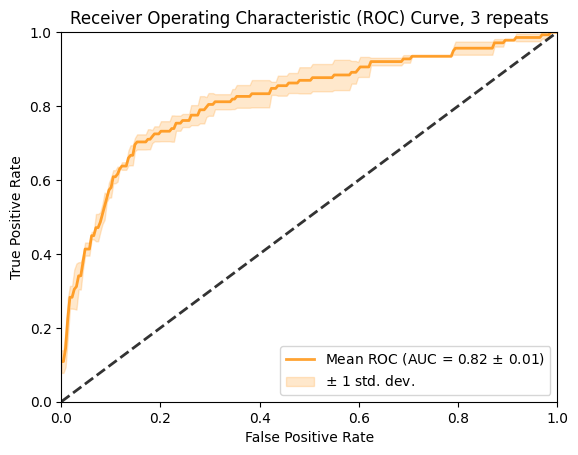

In [16]:
# plotting average ROC curve for all iterations
plt.figure()
plt.plot(mean_fpr, mean_tpr, color='darkorange', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)
plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='darkorange', alpha=.2, label=r'$\pm$ 1 std. dev.')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black', alpha=.8)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) Curve, {repeats} repeats')
plt.legend(loc="lower right")
plt.savefig('figures\\ROC_curve.png', bbox_inches='tight')
plt.show()

## Confusion Matrix

In [17]:
from sklearn.metrics import confusion_matrix
manual_y_preds = []
confusion_matrix_list = []
y_tests_combined_list = []
for j in range(repeats):
    #first need to find nan values in each optimised prob
    nan_indices = np.isnan(optimal_probs[j])

    
    encoded_health_state = np.array([0 if label == 'Unhealthy' else 1 for label in health_state])
    y_test = encoded_health_state[~nan_indices]

    y_pred = (optimal_probs[j] > threshold).astype(int)#will be threshold[j] when do repeats

    confusion_matrix_list.append(confusion_matrix(y_test, y_pred[~nan_indices]))

print(confusion_matrix_list)
average_confusion_matrix = np.mean(confusion_matrix_list, axis=0)
print(average_confusion_matrix)

# Calculate the variance and standard deviation
cm_variance = np.zeros((2, 2), dtype=float)
for cm in confusion_matrix_list:
    cm_variance += (cm - average_confusion_matrix) ** 2

cm_variance /= repeats
cm_std_dev = np.sqrt(cm_variance)

# rounding to integers
cm_avg_rounded = np.round(average_confusion_matrix).astype(int)
cm_std_dev_rounded = np.round(cm_std_dev).astype(int)


[array([[143,  30],
       [ 12,  34]], dtype=int64), array([[139,  34],
       [ 11,  35]], dtype=int64), array([[139,  36],
       [ 14,  32]], dtype=int64)]
[[140.33333333  33.33333333]
 [ 12.33333333  33.66666667]]


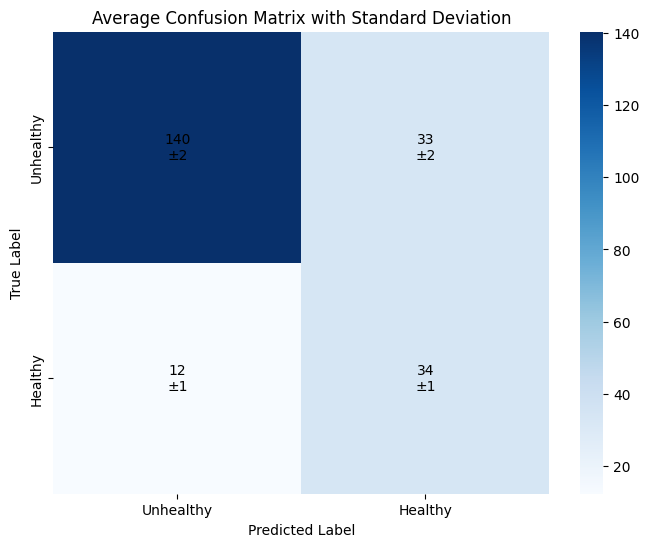

In [18]:
import seaborn as sns

# Create the heatmap
plt.figure(figsize=(8, 6))
ax = sns.heatmap(average_confusion_matrix, annot=False, cmap='Blues', xticklabels=['Unhealthy', 'Healthy'], yticklabels=['Unhealthy', 'Healthy'])

# Add annotations for both average values and standard deviation
for i in range(average_confusion_matrix.shape[0]):
    for j in range(average_confusion_matrix.shape[1]):
        plt.text(j + 0.5, i + 0.5, f'{cm_avg_rounded[i, j]}\n±{cm_std_dev_rounded[i, j]}', 
                 ha='center', va='center', color='black')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Average Confusion Matrix with Standard Deviation')
plt.savefig('figures\\confusion_matrix.png', bbox_inches='tight')
plt.show()

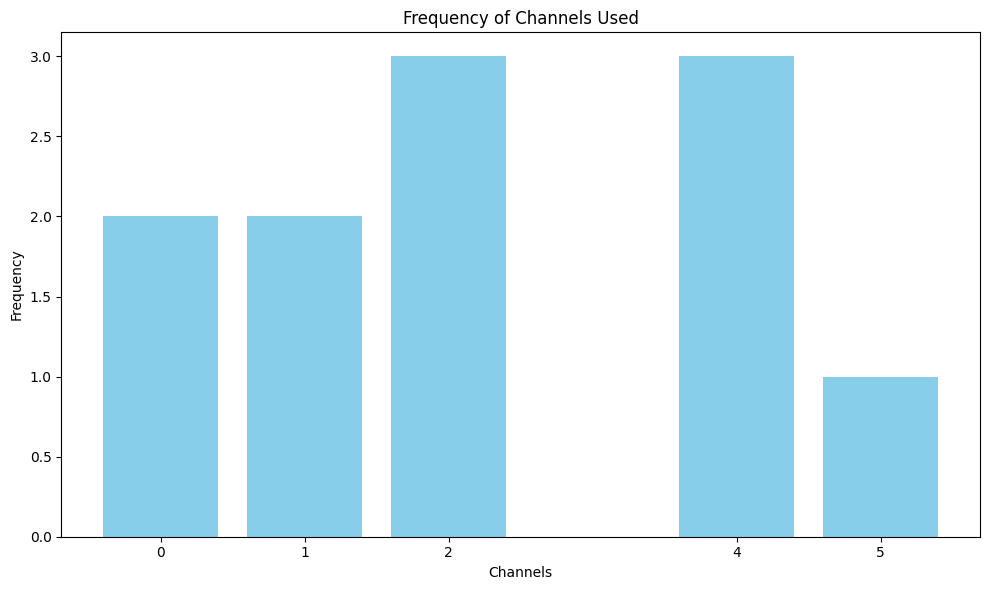

In [19]:
import matplotlib.pyplot as plt
from collections import Counter


# Flatten the list of lists
flattened_list = [number for sublist in best_channels for number in sublist]

# Count the occurrences of each number
counted_numbers = Counter(flattened_list)

# Sort the numbers to maintain a consistent order in the plot
sorted_numbers = sorted(counted_numbers.keys())
counts = [counted_numbers[number] for number in sorted_numbers]

# Plotting the results
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(sorted_numbers, counts, color='skyblue')

# Adding labels and title
ax.set_xlabel('Channels')
ax.set_ylabel('Frequency')
ax.set_title('Frequency of Channels Used')
ax.set_xticks(sorted_numbers)
ax.set_xticklabels(counted_numbers.keys())

# Show the plot
plt.tight_layout()
plt.savefig('figures\\number_frequency_bar_chart.png', bbox_inches='tight')
plt.show()

## Different filters:

In [5]:
different_denoise_methods = ['butterworth', 'DWT', None]

best_scores = []
best_channels = []

optimal_probs = []


#nan_indices_list = []
av_thresholds_list = []

scores_dict_list = []


for method in different_denoise_methods:
    #creating DATA object
    ptb_binary_SVM = Data(database = 'ptbdb', denoise_method=method, estimation_method = 'SVM', train_splits=None, binary = True, parameterisation = True)

    ptb_binary_SVM.run()

    input_data = ptb_binary_SVM.input_data
    labels = ptb_binary_SVM.labels
    
    metrics = {}
    
    probs_list = []
    thresholds_list = []

    for i in range(6):
        labels_encoded = np.array([0 if label == 'Unhealthy' else 1 for label in labels[i]])

        #define classifier
        svc = SVC(class_weight='balanced', probability = True)

        #find the best set of hyperparameters for each channel, tuned on the desired scoring function
        best_svc = tune_hyperparams(input_data[i], labels_encoded, param_grid, svc, scorer='roc_auc')

        #perform 3 way skfold to get scores for each channel as well as their probabilities
        n_splits = 3
        all_score_metrics, thresholds, probabilities, y_tests, test_indices = perform_skfold(input_data[i], labels_encoded, n_splits, best_svc, get_probabilities=True)

        #monitoring scores for each channel
        metrics[i] = all_score_metrics

        #calculating average threshold from all splits
        threshold = np.mean(thresholds)

        #reconstructing calculated probabilities so can optimise over all channels
        reconstructed_probs = reconstruct_probs(probabilities, test_indices, ptb_binary_SVM.nan_indices[i], ptb_binary_SVM.allowed_patients.count_patients(), n_splits)


        #need for ROC curve and confusion matrix later
        probs_list.append(reconstructed_probs)
        thresholds_list.append(threshold)

    


    #for averaging 
    scores_dict_list.append(metrics)

    #optimising over channels
    av_threshold = np.mean(thresholds_list)
    best_score, best_channel_indices = optimise_score_over_channels(probs_list, av_threshold, ptb_binary_SVM.health_state)#should put in here ability to input different score metrics

    best_scores.append(best_score)
    best_channels.append(best_channel_indices)


    #calculating optimal probability
    best_prob = average_probabilities(probs_list, best_channel_indices)
    optimal_probs.append(best_prob)
    av_thresholds_list.append(av_threshold)


Filtering Database


100%|██████████| 221/221 [00:02<00:00, 86.31it/s]


denoising signals through butterworth filter method
normalising signals
calculating time domain parameters
calculating frequency domain parameters
calculating non linear domain parameters
selecting 4 most important features
Selected features for channel 1:
['rr_amps', 'kurtosis', 'sd2', 'age']
Selected features for channel 2:
['hf', 'sd1', 'sd2', 'age']
Selected features for channel 3:
['rr_amps', 'std', 'sd_ratio', 'age']
Selected features for channel 4:
['lf', 'total_power', 'sd2', 'age']
Selected features for channel 5:
['rr_std', 'lf', 'total_power', 'age']
Selected features for channel 6:
['rr_amps', 'skews', 'lf', 'age']
Filtering Database


100%|██████████| 221/221 [00:00<00:00, 318.70it/s]


denoising signals through Discrete Wavelet Transform
normalising signals
calculating time domain parameters
calculating frequency domain parameters
calculating non linear domain parameters
selecting 4 most important features
Selected features for channel 1:
['rr_mean', 'rr_amps', 'shannon_en', 'age']
Selected features for channel 2:
['rr_amps', 'shannon_en', 'sd_ratio', 'age']
Selected features for channel 3:
['rr_std', 'sd1', 'sd2', 'age']
Selected features for channel 4:
['rr_amps', 'std', 'sd_ratio', 'age']
Selected features for channel 5:
['skews', 'shannon_en', 'sd2', 'age']
Selected features for channel 6:
['rr_std', 'mean', 'sd1', 'age']
Filtering Database


100%|██████████| 221/221 [00:00<00:00, 243.64it/s]


calculating time domain parameters
calculating frequency domain parameters
calculating non linear domain parameters
selecting 4 most important features
Selected features for channel 1:
['rr_amps', 'lf', 'sd2', 'age']
Selected features for channel 2:
['rr_std', 'rr_amps', 'power_ratio', 'age']
Selected features for channel 3:
['rr_std', 'rr_amps', 'kurtosis', 'age']
Selected features for channel 4:
['skews', 'shannon_en', 'sd2', 'age']
Selected features for channel 5:
['rr_amps', 'lf', 'sd2', 'age']
Selected features for channel 6:
['lf', 'total_power', 'sd2', 'age']


In [8]:
print(best_scores)

[0.5984251968503937, 0.6, 0.6]


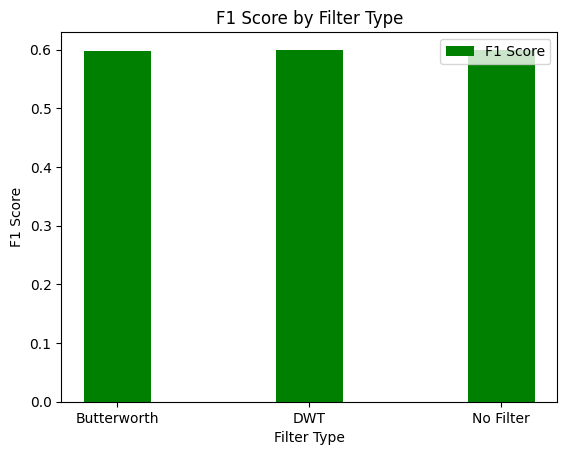

In [7]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

filter_names = ['Butterworth', 'DWT', 'No Filter']

# Define bar width
bar_width = 0.35

# Define positions for the bars
index = np.arange(len(filter_names))

# Plotting loss bars
accuracy_bars = ax1.bar(index, best_scores, bar_width, label='F1 Score', color='green')

# Set axis labels and title
ax1.set_xlabel('Filter Type')
ax1.set_ylabel('F1 Score')
ax1.set_title('F1 Score by Filter Type')
ax1.set_xticks(index)
ax1.set_xticklabels(filter_names)
ax1.legend()

plt.savefig('figures/score_vs_filter_type_svm.png', bbox_inches='tight')
plt.show()